In [ ]:
%load_ext autoreload
%autoreload 2
import copy
import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pyro
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, infer_discrete, autoguide
from pyro import poutine, infer, nn, distributions as dist

plt.style.use('seaborn-v0_8')

## Loss Grad

In [ ]:
pyro.set_rng_seed(0)
torch.manual_seed(0)
x = torch.empty(10).uniform_(-5, 5)
w = torch.randn(1).item()
y = w*x + 1e-2 * torch.randn(10)
plt.scatter(x, y)

In [ ]:
def model(x, y=None):
    p = pyro.sample("w", dist.Normal(-10, 10.))
    with pyro.plate("data", 10):
        pyro.sample("obs", dist.Normal(p*x, torch.tensor(1.0)), obs=y)

pyro.clear_param_store()
pyro.set_rng_seed(0)
torch.manual_seed(0)
guide = autoguide.AutoNormal(model=model)
optim = pyro.optim.Adam({"lr": 1e-2})
losses = []
svi = SVI(model, guide, optim, Trace_ELBO(1))
for i in range(1000):
    losses.append(svi.step(x, y))
    

In [ ]:
plt.plot(losses)

In [ ]:
torch.tensor(losses[:10])

In [ ]:
list(pyro.get_param_store().items())

In [69]:
def model(x, y=None):
    p = pyro.sample("w", dist.Normal(-10, 10.))
    with pyro.plate("data", 10):
        pyro.sample("obs", dist.Normal(p*x, torch.tensor(1.0)), obs=y)

pyro.clear_param_store()
pyro.set_rng_seed(0)
torch.manual_seed(0)
guide = autoguide.AutoNormal(model=model)
losses2 = []
svi = SVI(model, guide, optim, Trace_ELBO(1))

def train():
    guide_trace = poutine.trace(guide).get_trace(x, y)
    replay_model = poutine.replay(model, trace=guide_trace)
    trace = poutine.trace(replay_model).get_trace(x, y)
    
    elbo = 0
    elbo += trace.nodes["obs"]["fn"].log_prob(trace.nodes["obs"]["value"]).sum()
    
    elbo -= guide_trace.nodes["w"]["fn"].log_prob(guide_trace.nodes["w"]["value"]).sum()
    
    params = set(
            site["value"].unconstrained() for site in guide_trace.nodes.values() if site["type"] == "param"
        )
    optim = torch.optim.Adam(params, lr=1e-2)
    
    loss = -elbo
    loss.backward()
    optim.step()
    pyro.infer.util.zero_grads(params)
    
    return loss.item()    
        
for i in range(1000):
    loss = train()
    losses2.append(train())

In [70]:
losses2[:10]

[13.228569030761719,
 10.88357162475586,
 9.33586311340332,
 9.966324806213379,
 9.676599502563477,
 9.71802806854248,
 9.880288124084473,
 9.396834373474121,
 9.571087837219238,
 9.209325790405273]

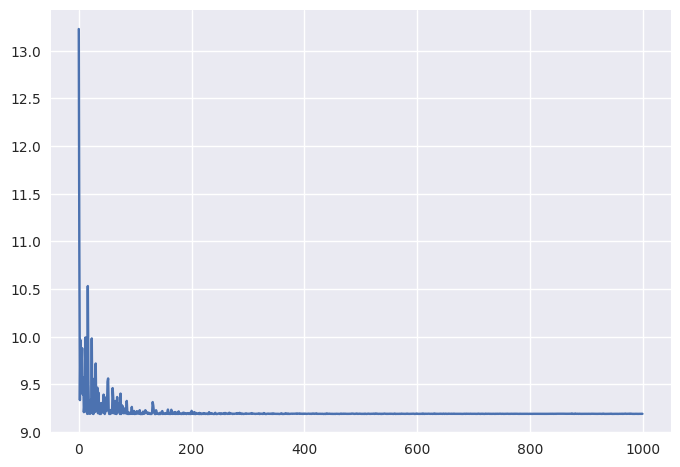

In [71]:
plt.plot(losses2)

In [72]:
list(pyro.get_param_store().items())

[('AutoNormal.locs.w',
  Parameter containing:
  tensor(0.1600, requires_grad=True)),
 ('AutoNormal.scales.w', tensor(0.0010, grad_fn=<SoftplusBackward0>))]

In [73]:
w

0.1603812575340271

## Gaussian Mixture

In [103]:
pyro.set_rng_seed(100)
torch.manual_seed(0)
K = 3
N = 10
w = None
c = 0
while c < 100:
    w = dist.Dirichlet(torch.empty(K).uniform_(0, 2.)).sample()
    if w.min() > 0.25:
        break
clusters = dist.Categorical(w).sample((N,))
locs = dist.Uniform(-5, 5).sample((K, )).sort().values
scales = dist.LogNormal(0, 1.).sample((K,))
components = [dist.Normal(locs[i], scales[i]) for i in range(K)]
mixtures_points = [components[i].sample() for i in clusters]

In [104]:
w, locs, scales

(tensor([0.3893, 0.2703, 0.3404]),
 tensor([-4.8583, -1.0143,  3.3622]),
 tensor([1.2537, 2.6778, 1.4333]))

In [105]:
data = torch.hstack(mixtures_points)
data

tensor([ 1.1176,  4.7003, -5.0363, -4.3728,  3.6215,  3.7799, -3.7588, -1.5503,
         5.1692, -3.1651])

In [106]:
@config_enumerate
def model(data, is_eval=False):
    weights = pyro.sample("weights", dist.Dirichlet(torch.ones(K) / K))
    
    with pyro.plate("mixture", K):
        l = pyro.sample("locs", dist.Normal(-10., 10.))
        s = pyro.sample("scales", dist.LogNormal(0., 10.))
    
    print("l: ", l)
    print("s: ", s)

    with pyro.plate("data", len(data)):
        clusters = pyro.sample("cluster", dist.Categorical(weights))
        if is_eval:
            model_mixt = pyro.sample("obs", dist.Normal(l[clusters], s[clusters]), 
                           )
        else:
            model_mixt = pyro.sample("obs", dist.Normal(l[clusters], s[clusters]), 
                            obs=data)
        print("clusters: ", clusters)
        print("model_mixt: ", model_mixt.size())
        
    return model_mixt  

In [194]:
def init_loc_fn(site):
    if site["name"] == "weights":
        value = torch.ones(K) / K
    elif site["name"] == "scales":
        value = dist.LogNormal(0, data.std()).sample([K])
    elif site["name"] == "locs":
        value = data[torch.multinomial(torch.ones_like(data).div(N), num_samples=K)]
    else:
        raise NotImplementedError
    
    return value


def train(data, is_eval, seed):
    optim = pyro.optim.Adam({"lr": 2e-3})
    elbo = TraceEnum_ELBO(max_plate_nesting=1) # log sum(p(x, z|θ)_z) - Σ_n q(θ|D) 
    pyro.clear_param_store()
    pyro.set_rng_seed(seed)
    torch.manual_seed(seed)

               

    losses = []
    svi = SVI(model, guide, optim, elbo)
    
    for i in range(1):
        losses.append(svi.step(data, is_eval))
        print("Losses: ", losses)
    
    svi.losses = losses
    return svi


In [195]:
train(data, False, 0)

l:  tensor([-5.0363,  3.7799,  4.7003])
s:  tensor([2.3204, 2.9925, 9.3647])
clusters:  tensor([2, 0, 2, 1, 1, 2, 0, 1, 2, 2])
model_mixt:  torch.Size([10])
l:  tensor([-5.0363,  3.7799,  4.7003], grad_fn=<ExpandBackward0>)
s:  tensor([2.3204, 2.9925, 9.3647], grad_fn=<ExpandBackward0>)
clusters:  tensor([[0],
        [1],
        [2]])
model_mixt:  torch.Size([10])
Losses:  [55.42920684814453]


In [184]:
0.7590-sum([-4.0668, -4.3237, -5.4835]) - sum([-3.3447, -4.1710, -4.3020]) + 28.978500000000004

55.4292

In [178]:
sum([-3.1052, -2.8719, -2.7157, -2.7336, -2.8381, -2.8368, -2.8042, -3.2442,
        -2.9172, -2.9116])

-28.978500000000004

In [124]:
z = torch.tensor([[ -5.2775, -10.5645,  -1.7607,  -1.8015,  -8.7217,  -8.9787,  -1.9122,
          -2.8892, -11.4328,  -2.0858],
        [ -2.4108,  -2.0624,  -6.3547,  -5.7261,  -2.0165,  -2.0151,  -5.1882,
          -3.6013,  -2.1228,  -4.7080],
        [ -3.2291,  -3.1559,  -3.6964,  -3.6252,  -3.1625,  -3.1607,  -3.5639,
          -3.3786,  -3.1571,  -3.5086]])

In [125]:
z

tensor([[ -5.2775, -10.5645,  -1.7607,  -1.8015,  -8.7217,  -8.9787,  -1.9122,
          -2.8892, -11.4328,  -2.0858],
        [ -2.4108,  -2.0624,  -6.3547,  -5.7261,  -2.0165,  -2.0151,  -5.1882,
          -3.6013,  -2.1228,  -4.7080],
        [ -3.2291,  -3.1559,  -3.6964,  -3.6252,  -3.1625,  -3.1607,  -3.5639,
          -3.3786,  -3.1571,  -3.5086]])

In [126]:
z.sum()

tensor(-125.2685)

In [127]:
-0.7590-11.8177-13.8739-32.9584

-59.409

In [128]:
125.2686-59.409

65.8596

In [172]:
v = torch.tensor([[ -5.2775, -10.5645,  -1.7607,  -1.8015,  -8.7217,  -8.9787,  -1.9122,
          -2.8892, -11.4328,  -2.0858],
        [ -2.4108,  -2.0624,  -6.3547,  -5.7261,  -2.0165,  -2.0151,  -5.1882,
          -3.6013,  -2.1228,  -4.7080],
        [ -3.2291,  -3.1559,  -3.6964,  -3.6252,  -3.1625,  -3.1607,  -3.5639,
          -3.3786,  -3.1571,  -3.5086]]).exp() * torch.tensor([-1.0986, -1.0986, -1.0986]).unsqueeze(1).exp()

In [175]:
v.sum(0).log().sum()

tensor(-28.9784)

In [187]:
sum([-3.1052, -2.8719, -2.7157, -2.7336, -2.8381, -2.8368, -2.8042, -3.2442,
        -2.9172, -2.9116])

-28.978500000000004